### Ask if rule can be decoded during fb period if we only look at correct last 8 trials

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.feature_block_splitter import FeatureBlockSplitter
from trial_splitters.kfold_block_splitter import KFoldBlockSplitter

from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 14})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
# only look at corrects for this one
valid_beh = behavior_data[behavior_data.Response.isin(["Correct"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

### Grab only last 8 per trial

In [3]:
# get rules with more than 5 blocks associated with them
valid_beh_cor_only = valid_beh[valid_beh.Response == "Correct"]

num_rules = valid_beh_cor_only.groupby(["CurrentRule"]).apply(lambda x: len(x.BlockNumber.unique()))
rules_more_than_five = num_rules[num_rules > 5].index.values

last_n = 8

def label_trials(block_group, last_n):
    block_len = len(block_group)
    block_group["TrialUntilRuleChange"] = block_len - block_group["TrialAfterRuleChange"]
    last_eight = block_group[block_group["TrialUntilRuleChange"] <= last_n]
    return last_eight
block_groups = valid_beh_cor_only.groupby(["BlockNumber"], as_index=False)
only_last_n = block_groups.apply(label_trials, last_n).reset_index()

valid_beh_cor_only = valid_beh_cor_only[
    (valid_beh_cor_only.TrialNumber.isin(only_last_n.TrialNumber)) & 
    (valid_beh_cor_only.CurrentRule.isin(rules_more_than_five)) 
]

In [4]:
frs = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))
feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))

In [5]:
# only look at trial numbers of last eights
frs = frs[frs.TrialNumber.isin(valid_beh_cor_only.TrialNumber)]

### Run Training, Random splits

In [20]:
num_neurons = len(frs.UnitID.unique())
classes = valid_beh_cor_only["CurrentRule"].unique()
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = frs.rename(columns={mode: "Value"})
labels = valid_beh_cor_only.rename(columns={"CurrentRule": "Feature"})

splitter = RandomSplitter(valid_beh_cor_only.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), splitter
)
io_utils.save_model_outputs(
    fs, 
    f"fb_rule_last_eights_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

cuda
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


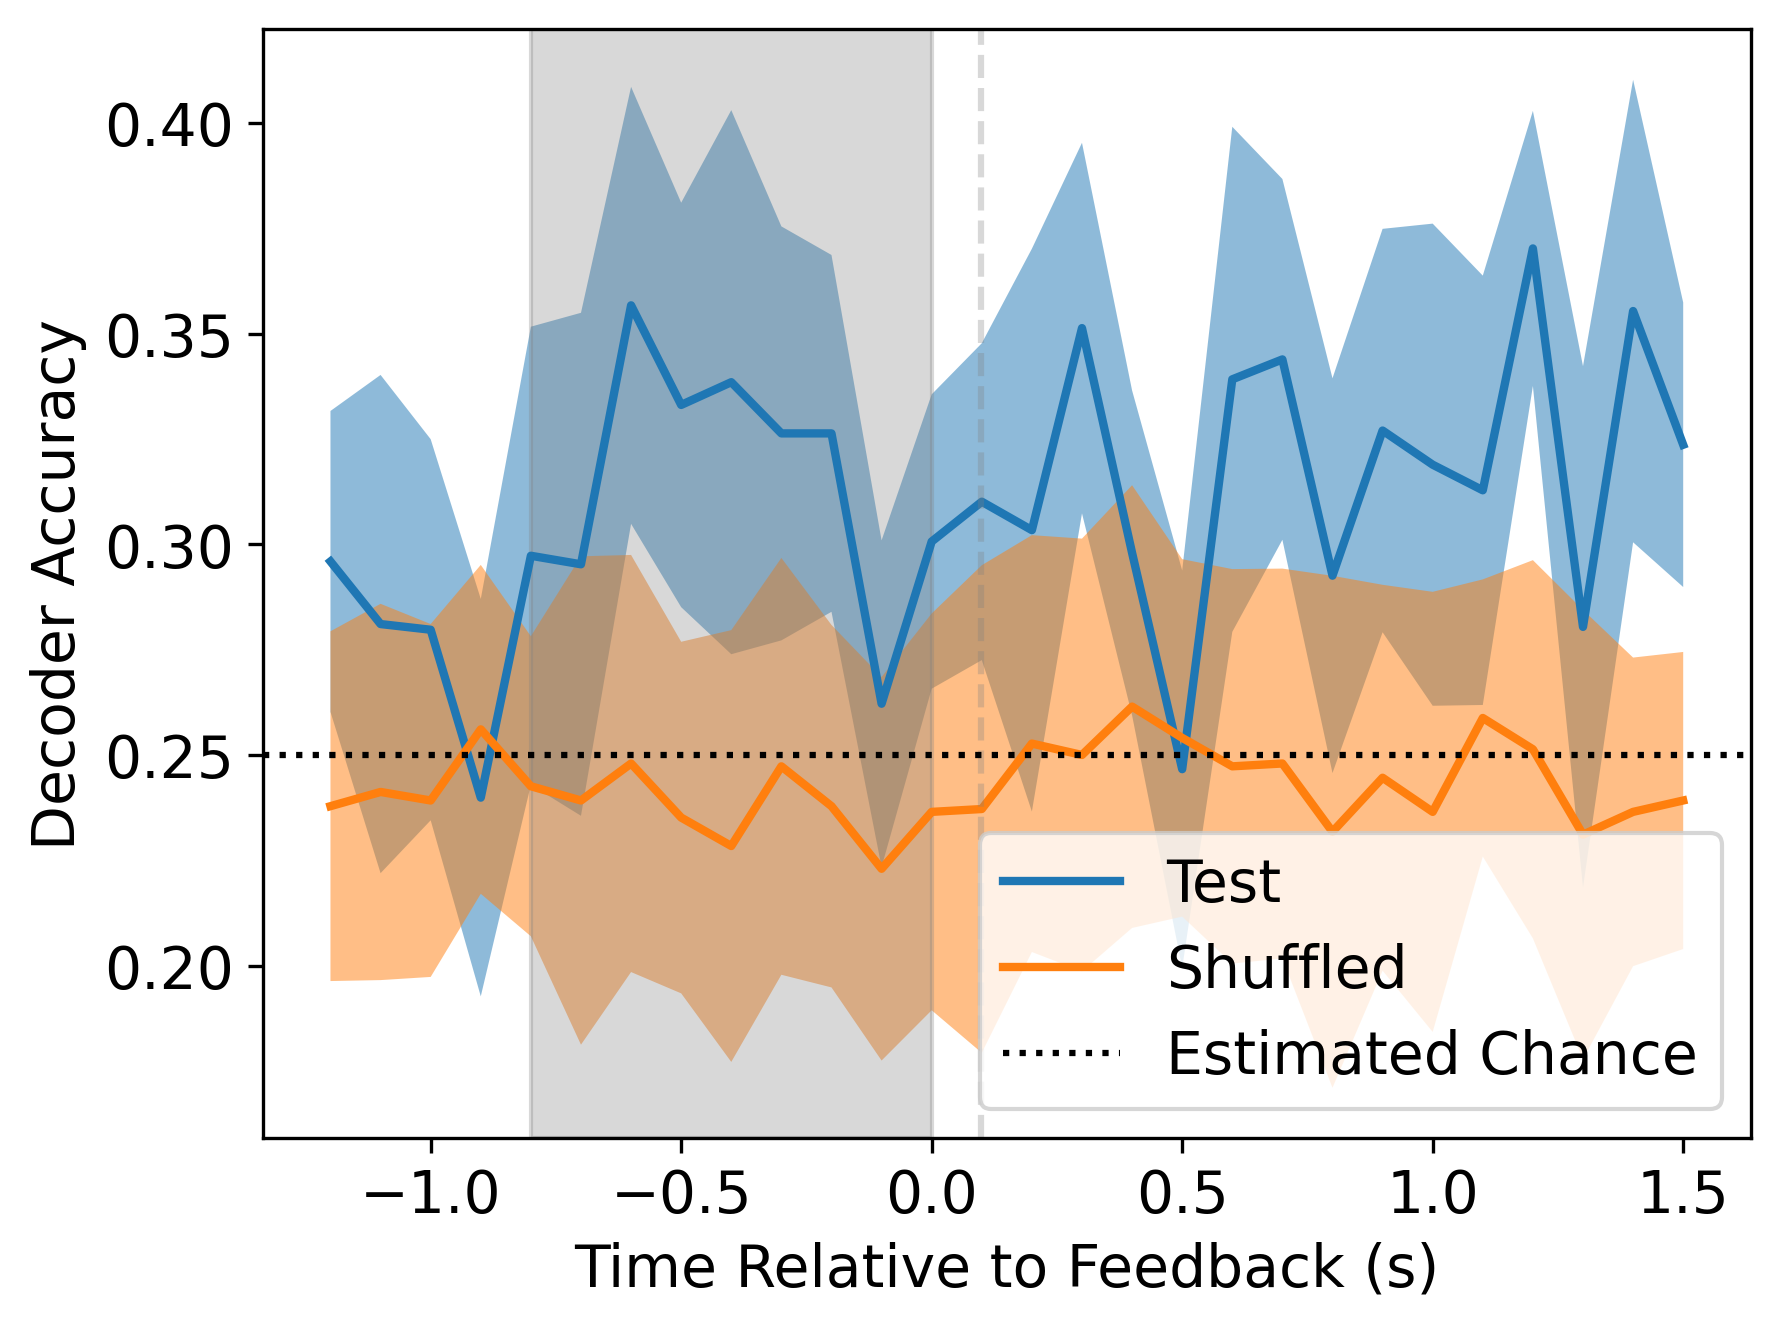

In [25]:
fig, ax = plt.subplots()

_, test_accs_by_bin, shuffled, _, _ = io_utils.load_model_outputs(
    fs, 
    f"fb_rule_last_eights_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label=f"Test",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled,
    1.3, 1.5, 0.1,
    ax,
    label=f"Shuffled",
    right_align=True, 
    # color='black'
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Now for block splits

In [7]:
num_neurons = len(frs.UnitID.unique())
classes = valid_beh_cor_only["CurrentRule"].unique()
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = frs.rename(columns={mode: "Value"})
labels = valid_beh_cor_only.rename(columns={"CurrentRule": "Feature"})

splitter = KFoldBlockSplitter(valid_beh_cor_only, 5)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), splitter
)
io_utils.save_model_outputs(
    fs, 
    f"fb_rule_last_eights_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "kfoldblock_split",
    outputs
)

cpu
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


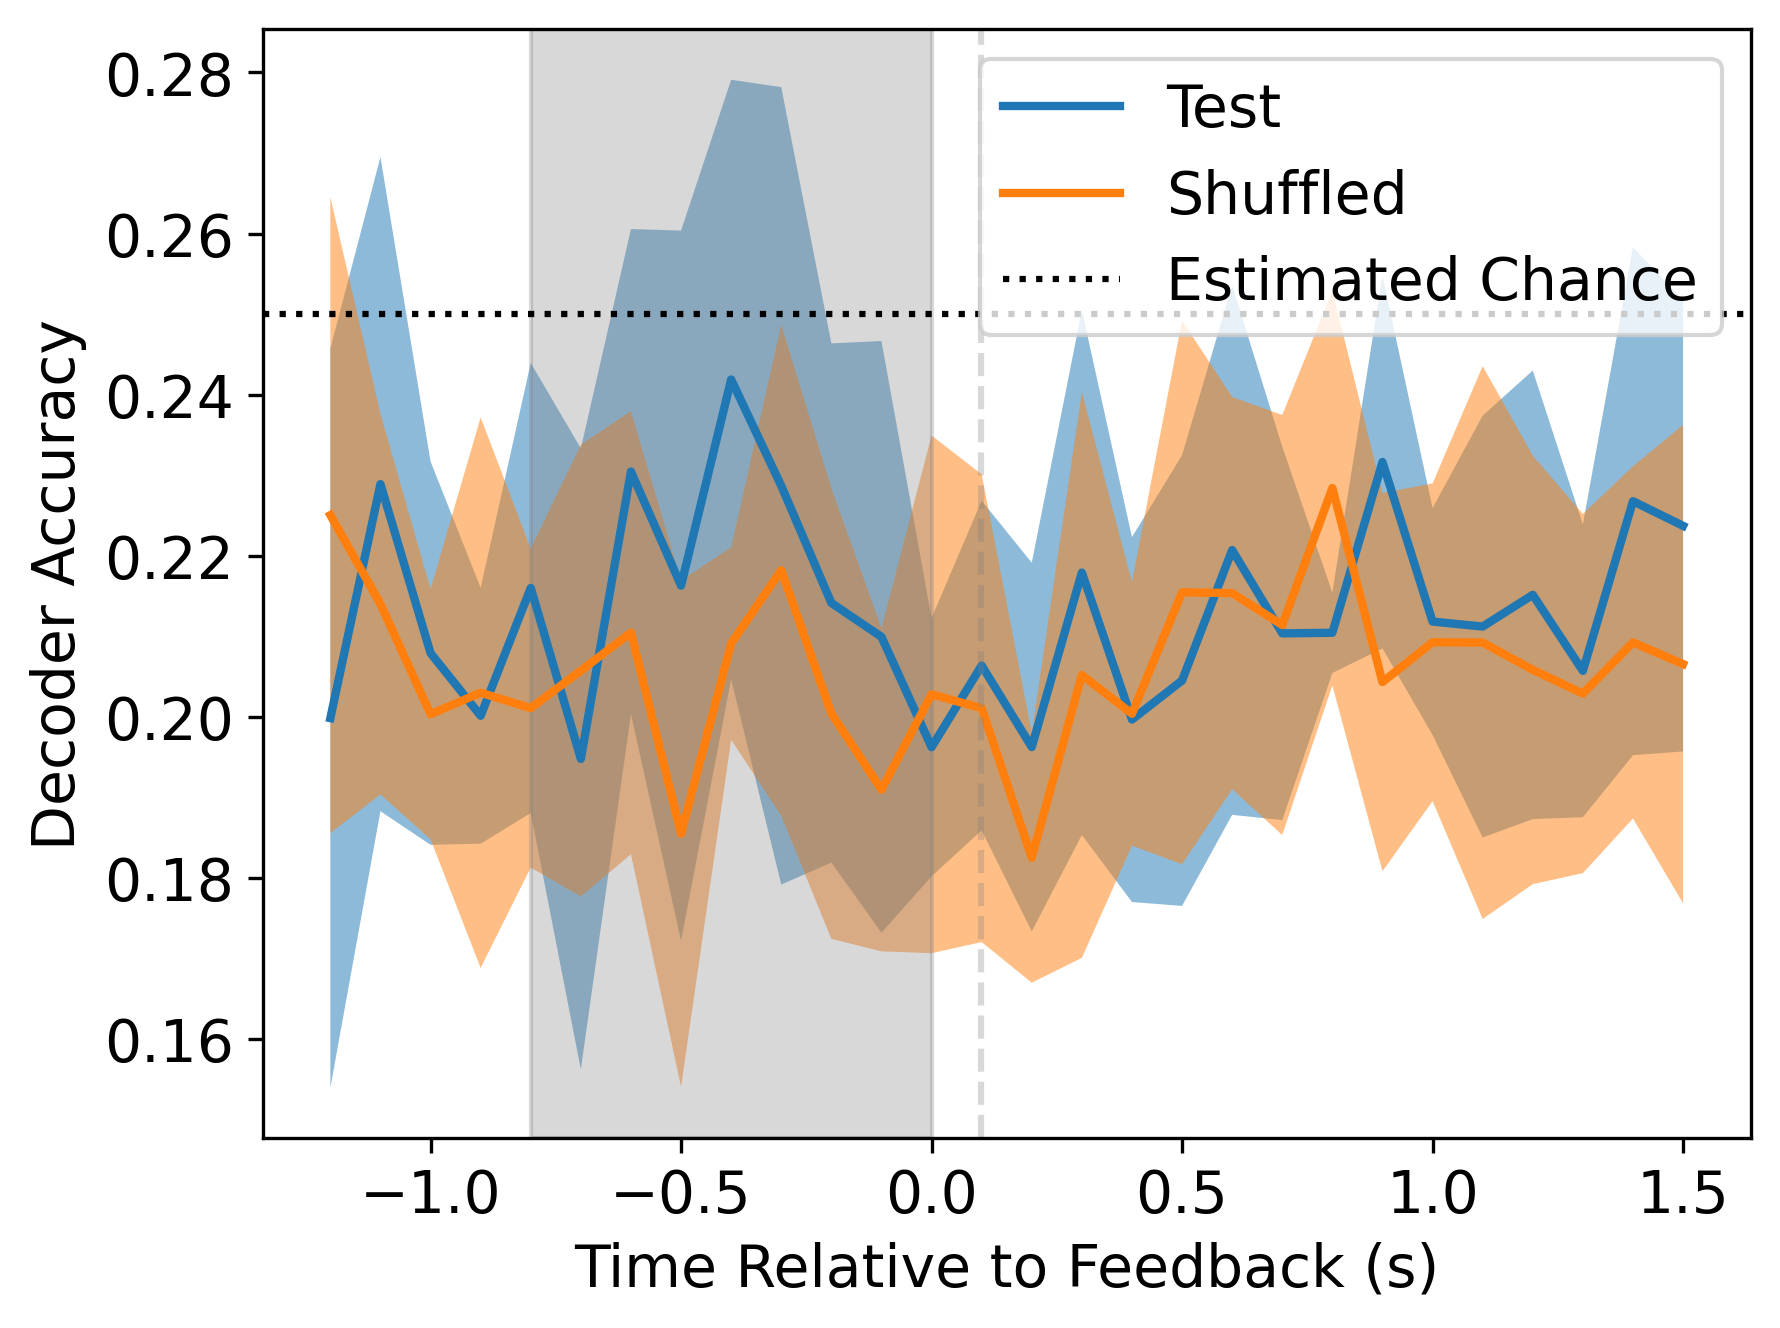

In [8]:
fig, ax = plt.subplots()

_, test_accs_by_bin, shuffled, _, _ = io_utils.load_model_outputs(
    fs, 
    f"fb_rule_last_eights_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "kfoldblock_split",
)

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label=f"Test",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled,
    1.3, 1.5, 0.1,
    ax,
    label=f"Shuffled",
    right_align=True, 
    # color='black'
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})